https://www.kaggle.com/datasets/sergeynesteruk/apple-rotting-segmentation-problem-in-the-wild

In [1]:
#from google.colab import drive
#drive.mount('/content/drive')

In [2]:
#1- Import Libraries
import os
import glob
import random
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from PIL import Image
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

In [3]:
#1- Import Pytorch Libraries
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torch.utils.data as data
import torchvision.utils as vutils
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from torchvision.transforms import functional

In [4]:
# set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cpu')

In [5]:
#2- Define Paths:
num_classes = 3 # after grouping

folder_train = 'max_data/train/'
folder_test = 'max_data/test/'
folder_background = 'Sk_background/'
folder_wild = 'wild/'

In [6]:
#3- Data Analysis & Split Dataset
# image in folder train .jpg and mask .png 
image_names_path = sorted(glob.glob(os.path.join(folder_train, "*.jpg")))
mask_names_path = sorted(glob.glob(os.path.join(folder_train, "*.png")))
image_background = sorted(glob.glob(os.path.join(folder_background, "*.JPG")))

In [7]:
image_names = [x.split('/')[-1] for x in image_names_path]
mask_names = [x.split('/')[-1] for x in mask_names_path]

In [8]:
# only the image array will be used and 'obj' will be replaced by 'mask'. 
temp_array = [string.replace('obj', 'msk') for string in image_names]
modified_array = [string.replace('jpg', 'png') for string in temp_array]
# check if array are the same
modified_array == mask_names # if two lists have the same elements in the same order
# set(mask_names) == set(modified_array) # if two lists have the same elements, regardless of their order 

True

In [9]:
# image in folder test .jpg and mask .png 
test_image_names_path = sorted(glob.glob(os.path.join(folder_test, "*.jpg")))
test_mask_names_path = sorted(glob.glob(os.path.join(folder_test, "*.png")))

test_image_names = [x.split('/')[-1] for x in test_image_names_path]
test_mask_names = [x.split('/')[-1] for x in test_mask_names_path]

In [10]:
# only the image array will be used and 'obj' will be replaced by 'mask'. 
temp_array = [string.replace('obj', 'msk') for string in test_image_names]
modified_array = [string.replace('jpg', 'png') for string in temp_array]
# check if array are the same
modified_array == test_mask_names # if two lists have the same elements in the same order
# set(mask_names) == set(modified_array) # if two lists have the same elements, regardless of their order

True

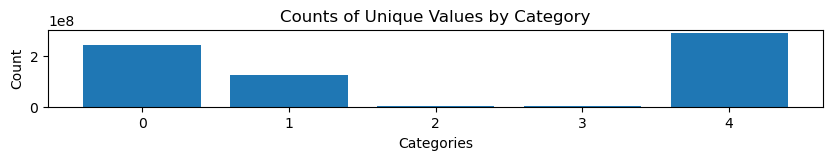

In [11]:
# create a bar chart of the value_counts dictionary
value_counts = {0: 243684720, 4: 290920946, 1: 126954028, 2: 1560020, 3: 1509608}
fig = plt.figure(figsize=(10, 1))
plt.bar(value_counts.keys(), value_counts.values())

# set the axis labels and title
plt.xlabel("Categories")
plt.ylabel("Count")
plt.title("Counts of Unique Values by Category")

# show the plot
plt.show()

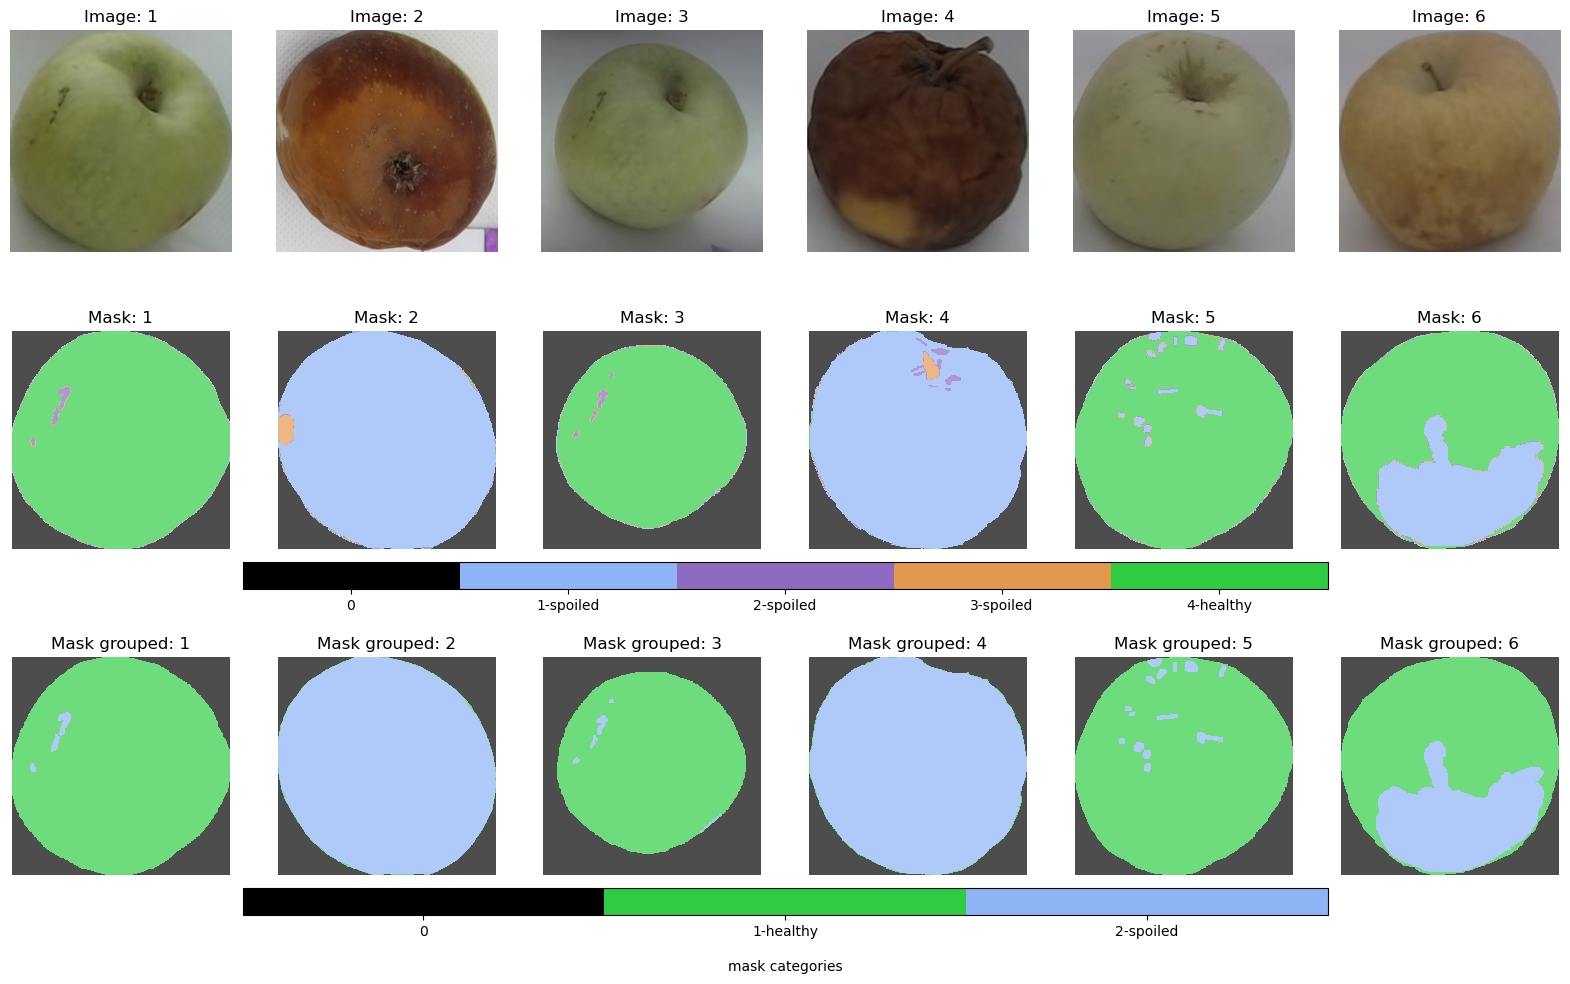

In [12]:
# mask categories
import matplotlib.colors as mcolors

# Define five custom colors
colors = ['#000000', '#8DB4F5', '#8E6BC1', '#E4984D', '#2FCC43']
colors2 = ['#000000', '#2FCC43', '#8DB4F5']
# Create a colormap from the custom colors
cmap = mcolors.ListedColormap(colors)
cmap2 = mcolors.ListedColormap(colors2)

# Create a figure 
fig, axs = plt.subplots(3, 6, figsize=(20, 12))

# Loop over the array list and plot each array
for i, img_selected in enumerate(random.sample(image_names, 6)):
    mask_selected = img_selected.replace('obj', 'msk').replace('jpg', 'png')
    row_index = i // 6
    col_index = i % 6
    
    # Plot image and mask in first and second row respectively
    if row_index == 0:
        axs[0, col_index].imshow(Image.open(folder_train + img_selected).resize((224,224)))
        axs[0, col_index].set_title('Image: '+str(i+1))
        axs[0, col_index].axis('off') 

        axs[1, col_index].imshow(Image.open(folder_train + mask_selected).resize((224,224)), alpha=0.7, cmap=cmap)
        axs[1, col_index].set_title('Mask: '+str(i+1))
        axs[1, col_index].axis('off')
        
        mask_grouped=Image.open(folder_train + mask_selected)
        # PIL to array
        mask_grouped = np.array(mask_grouped) 
        # group categories  
        # 0 - background      <-- 0 
        # 1 - healthy apple   <-- 4 
        # 2 - spoiled apple   <-- 1,2,3
        mask_grouped[np.where((mask_grouped == 1) | (mask_grouped == 2) | (mask_grouped == 3))] = 2
        mask_grouped[np.where(mask_grouped == 4)] = 1
        # mask array to PIL
        mask_grouped = Image.fromarray(mask_grouped.astype('uint8'), 'L')
        axs[2, col_index].imshow(mask_grouped.resize((224,224)), alpha=0.7, cmap=cmap2)
        axs[2, col_index].set_title('Mask grouped: '+str(i+1))
        axs[2, col_index].axis('off')

# Add color bar below the second row
norm = plt.Normalize(0, 5)
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
cbar = plt.colorbar(sm, ax=axs[1, :], orientation='horizontal', pad=0.05, ticks=[0, 1, 2, 3, 4], shrink=0.7, aspect=40)
cbar.ax.set_xticks([0.5, 1.5, 2.5, 3.5, 4.5])
cbar.ax.set_xticklabels(['0', '1-spoiled', '2-spoiled', '3-spoiled', '4-healthy'])
#cbar.set_label('mask categories', labelpad=14)

# Create a second ScalarMappable object with a different normalization range
norm2 = plt.Normalize(0, 3)
sm2 = plt.cm.ScalarMappable(cmap=cmap2, norm=norm2)
sm2.set_array([])
# Add a color bar below the third row
cbar2 = plt.colorbar(sm2, ax=axs[2, :], orientation='horizontal', pad=0.05, ticks=[0, 1, 2], shrink=0.7, aspect=40)
cbar2.ax.set_xticks([0.5, 1.5, 2.5])
cbar2.ax.set_xticklabels(['0', '1-healthy', '2-spoiled'])
cbar2.set_label('mask categories', labelpad=15)

plt.show()


In [13]:
# Split Dataset
train_filenames, val_filenames = train_test_split(image_names, test_size=0.2, random_state=42, shuffle=True)

In [14]:
# Print number of samples in each set
print(f'Total Images: {len(image_names)}')
print(f'Total Masks: {len(mask_names)}')
print(f'Training samples: {len(train_filenames)}')
print(f'Validation samples: {len(val_filenames)}')
print(f'Testing samples: {len(test_image_names)}')

Total Images: 2958
Total Masks: 2958
Training samples: 2366
Validation samples: 592
Testing samples: 1276


In [15]:
#4- Define custom Datasets, data augmentation, Data Loaders
#num_classes for one hot encode
class CustomDataset(Dataset):
    def __init__(self, folder, image_filenames, image_background, transforms=None):
        self.folder = folder
        self.image_background = image_background
        self.image_filenames = image_filenames
        self.transforms = transforms
        
    def __len__(self):
        return len(self.image_filenames)
    
    def one_hot_encode(self, mask):
        mask = np.array(mask)
        one_hot = np.zeros((mask.shape[0], mask.shape[1], num_classes))
        for i in range(num_classes):
            one_hot[:, :, i] = (mask == i)
        return one_hot.astype(np.float32) 
        # one_hot = np.eye(num_classes)[mask].transpose(2, 0, 1).astype(np.float32
    
    def __getitem__(self, idx):
        image_name = self.image_filenames[idx]
        mask_name = image_name.replace('obj', 'msk').replace('jpg', 'png')
        image_path = os.path.join(self.folder, image_name)
        mask_path = os.path.join(self.folder, mask_name)

        image = Image.open(image_path).convert('RGB')
        mask = Image.open(mask_path).convert('L')
        # PIL to array
        mask = np.array(mask)        
        # Group categories
        # 0 - background      <-- 0 / # 1 - healthy apple   <-- 4 / # 2 - spoiled apple   <-- 1,2,3
        mask[np.where((mask == 1) | (mask == 2) | (mask == 3))] = 2
        mask[np.where(mask == 4)] = 1
           
        # mask array to PIL
        mask = Image.fromarray(mask.astype('uint8'), 'L')
            
        if self.transforms is not None:
            seed = np.random.randint(2023)
            
            random.seed(seed)
            torch.manual_seed(seed)
            image = self.transforms(image)
            
            random.seed(seed)
            torch.manual_seed(seed)
            mask = self.transforms(mask)
            
            image = transforms.ToTensor()(image)
            image = transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])(image)
            
            mask = self.one_hot_encode(mask)
            ## one_hot = np.eye(num_classes)[mask].transpose(2, 0, 1).astype(np.float32
            mask = transforms.ToTensor()(mask)
            
            return image, mask    

In [16]:
# Define data augmentation

image_size = (224, 224)

train_transforms = transforms.Compose([
    transforms.Resize(image_size),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomVerticalFlip(p=0.5),
    transforms.RandomRotation(degrees=(-90,90)),
     ]) #transforms.ToTensor()

val_transforms = transforms.Compose([
    transforms.Resize(image_size),
    ]) # transforms.ToTensor() 

In [17]:
# Create datasets and data loaders
train_dataset = CustomDataset(folder_train, train_filenames, image_background, train_transforms)
val_dataset = CustomDataset(folder_train, val_filenames, image_background, val_transforms)
test_dataset = CustomDataset(folder_test, test_image_names, image_background, val_transforms)

batch_size = 20
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


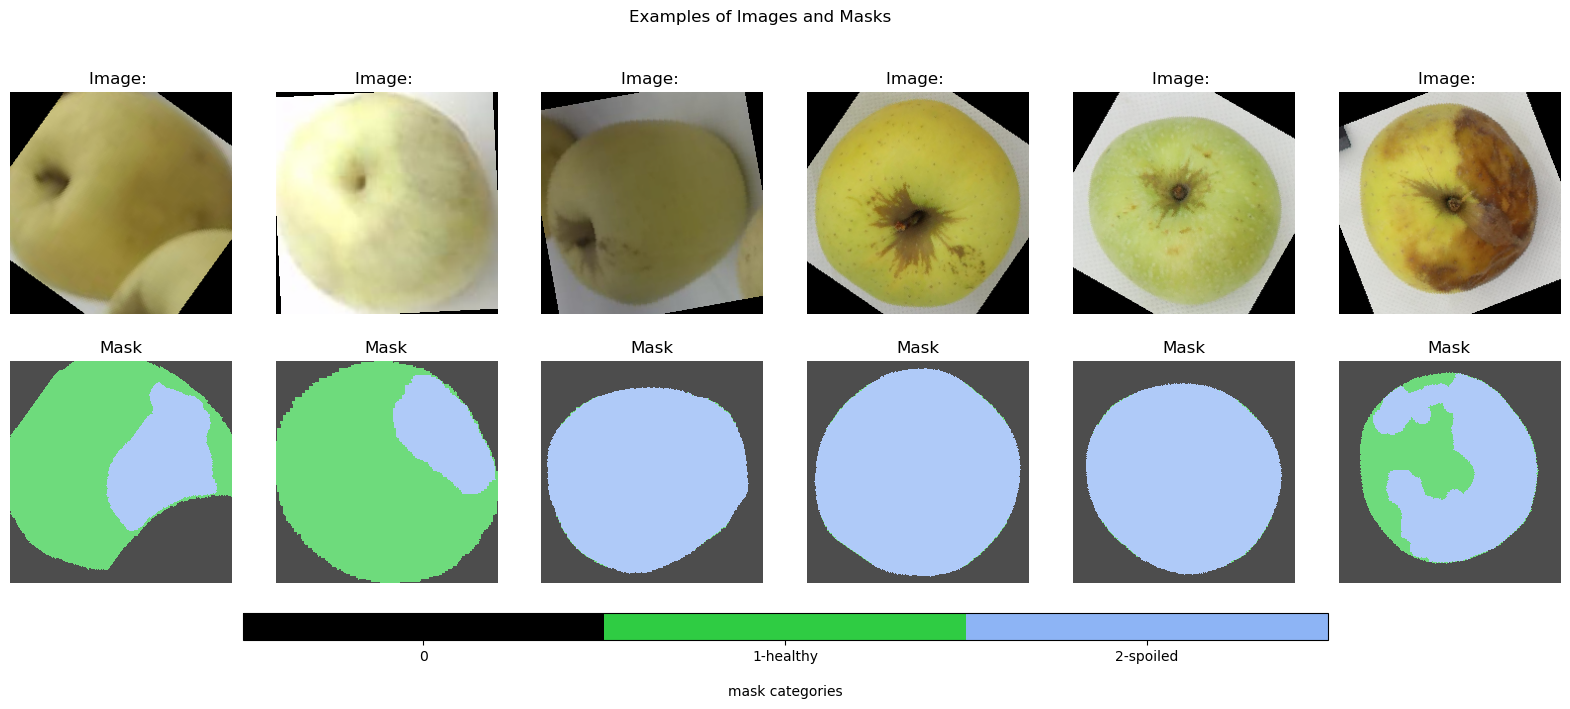

In [18]:
#5- Plot examples of image and mask pairs

images, masks = next(iter(train_loader))
mean=[0.485, 0.456, 0.406]
std=[0.229, 0.224, 0.225]
def plot_image_mask_pairs(images, masks, num_pairs=6):
    fig, axs = plt.subplots(nrows=2, ncols=6, figsize=(20, 8))
    fig.suptitle('Examples of Images and Masks')

    for i in range(num_pairs):
        # Plot image
        axs[0, i].imshow(np.clip(images[i].permute(1,2,0).numpy()* std + mean, 0, 255))
        axs[0, i].set_title('Image: ')
        axs[0, i].axis('off')    
        # Plot mask
        axs[1, i].imshow(torch.argmax(masks[i], dim=0), alpha=0.7, cmap=cmap2)
        axs[1, i].set_title('Mask')
        axs[1, i].axis('off')
        
    # Add color bar below the second row
    norm = plt.Normalize(0, 3)
    sm = plt.cm.ScalarMappable(cmap=cmap2, norm=norm)
    sm.set_array([])
    cbar = plt.colorbar(sm, ax=axs[:, :], orientation='horizontal', pad=0.05, ticks=[0, 1, 2], shrink=0.7, aspect=40)
    cbar.ax.set_xticks([0.5, 1.5, 2.5])
    cbar.ax.set_xticklabels(['0', '1-healthy', '2-spoiled'])
    cbar.set_label('mask categories', labelpad=15)
   
    plt.show()

plot_image_mask_pairs(images, masks)

In [19]:
images[0].type(), masks[0].type()

('torch.FloatTensor', 'torch.FloatTensor')

In [20]:
images[0].size(), masks[0].size()

(torch.Size([3, 224, 224]), torch.Size([3, 224, 224]))

In [21]:
#6- Define Model
#!pip install git+https://github.com/qubvel/segmentation_models.pytorch --quiet
import segmentation_models_pytorch as smp
import time
model = smp.Unet('mobilenet_v2', encoder_weights='imagenet', classes=num_classes, activation=None, 
                 encoder_depth=5, decoder_channels=[256, 128, 64, 32, 16])
model = model.to(device)

In [22]:
#7- Define Loss Function, Optimizer, scheduler and Early Stopping class:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=5, verbose=True)

In [23]:
# Early stopping class
class EarlyStopping:
    def __init__(self, patience=5, delta=0, mode='min'):
        self.patience = patience
        self.delta = delta
        self.mode = mode
        self.counter = 0
        self.best_score = None
        self.early_stop = False

        if self.mode == 'min':
            self.val_score = np.Inf
        else:
            self.val_score = -np.Inf

    def __call__(self, epoch_score, model, model_path):
        if self.mode == 'min':
            score = -1.0 * epoch_score
        else:
            score = np.copy(epoch_score)

        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(epoch_score, model, model_path)
        elif score < self.best_score + self.delta:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(epoch_score, model, model_path)
            self.counter = 0

    def save_checkpoint(self, epoch_score, model, model_path):
        torch.save({'epoch_score': epoch_score, 'model_state_dict': model.state_dict()}, model_path)


In [24]:
#8- Define metrics

def iou_score(outputs, targets, smooth=1e-6):
    intersection = (outputs & targets).sum()
    union = (outputs | targets).sum()
    iou = (intersection + smooth) / (union + smooth)
    return iou

def pixel_accuracy(outputs, targets):
    correct = (outputs == targets).sum()
    total = targets.numel()
    accuracy = correct / total
    return accuracy

def mean_accuracy(outputs, targets):
    class_accs = []
    for c in range(23):
        class_pixels = (targets == c).sum()
        correct = ((outputs == c) & (targets == c)).sum()
        if class_pixels == 0:
            class_acc = 0
        else:
            class_acc = correct / class_pixels
        class_accs.append(class_acc)
    mean_acc = torch.tensor(class_accs).cpu().numpy().mean()
    return mean_acc

def f1_score(outputs, targets, smooth=1e-6):
    tp = ((outputs == 1) & (targets == 1)).sum()
    fp = ((outputs == 1) & (targets == 0)).sum()
    fn = ((outputs == 0) & (targets == 1)).sum()
    precision = tp / (tp + fp + smooth)
    recall = tp / (tp + fn + smooth)
    f1 = 2 * (precision * recall) / (precision + recall + smooth)
    return f1

def dice_score(outputs, targets, smooth=1e-6):
    intersection = (outputs & targets).sum()
    dice = (2 * intersection + smooth) / (outputs.sum() + targets.sum() + smooth)
    return dice


In [25]:
#9- Define and execute Training Loop and Validation loop

class TrainerClass:
    def __init__(self, model, train_loader=None, val_loader=None, optimizer=None, criterion=None, scheduler=None, num_epochs=None, early_stopping_patience=None):
        self.num_epochs = num_epochs
        self.model = model
        self.train_loader = train_loader
        self.val_loader = val_loader
        self.optimizer = optimizer
        self.criterion = criterion
        self.scheduler = scheduler
        self.early_stopping = EarlyStopping(patience=early_stopping_patience)
        
        self.history = {
            'train_loss': [], 
                'train_iou': [], 'train_pixel_acc': [], 'train_mean_acc': [], 'train_f1': [], 'train_dice': [],
            'val_loss': [],
                 'val_iou': [], 'val_pixel_acc': [], 'val_mean_acc': [], 'val_f1': [], 'val_dice': [] }

    def run_one_epoch(self, loader, is_training):
        if is_training:
            self.model.train()
        else:
            self.model.eval()

        epoch_metrics = { 'loss': 0, 'iou': 0, 'pixel_acc': 0, 'mean_acc': 0,  'f1': 0, 'dice': 0 }

        with torch.set_grad_enabled(is_training):
            for inputs, targets in tqdm(loader, leave=False):
                inputs = inputs.to(device)
                targets = targets.to(device)

                # Forward pass
                outputs = self.model(inputs)
                loss = self.criterion(outputs, targets)

                if is_training:
                    # Backward pass and optimization
                    self.optimizer.zero_grad()
                    loss.backward()
                    self.optimizer.step()

                pred_masks = F.softmax(outputs, dim=1) ##
                pred_masks = torch.argmax(pred_masks, dim=1)
                pred_masks = pred_masks.unsqueeze(1).long()
                pred_masks = pred_masks.long()
                targets = targets.long()
                
                # Compute the metrics
                epoch_metrics['loss'] += loss.item() * inputs.size(0)
                epoch_metrics['iou'] += iou_score(pred_masks, targets) * inputs.size(0)
                epoch_metrics['pixel_acc'] += pixel_accuracy(pred_masks, targets) * inputs.size(0)
                epoch_metrics['mean_acc'] += mean_accuracy(pred_masks, targets) * inputs.size(0)
                epoch_metrics['f1'] += f1_score(pred_masks, targets) * inputs.size(0)
                epoch_metrics['dice'] += dice_score(pred_masks, targets) * inputs.size(0)

        epoch_metrics = {k: v / len(loader.dataset) for k, v in epoch_metrics.items()}

        if is_training:
            prefix = 'train'
        else:
            prefix = 'val'

        for k, v in epoch_metrics.items():
            self.history[f'{prefix}_{k}'].append(v)

        return epoch_metrics['loss'], epoch_metrics['iou'], epoch_metrics['pixel_acc'], epoch_metrics['mean_acc'], epoch_metrics['f1'], epoch_metrics['dice']

    def train_and_validate(self):
        for epoch in range(self.num_epochs):

            train_loss, train_iou, train_pixel_acc, train_mean_acc, train_f1, train_dice = self.run_one_epoch(self.train_loader, is_training=True)
            val_loss, val_iou, val_pixel_acc, val_mean_acc, val_f1, val_dice = self.run_one_epoch(self.val_loader, is_training=False)

            print(f'Epoch {epoch+1}/{self.num_epochs}')
            print(f'Train Loss: {train_loss:.4f}, Train IoU: {train_iou:.4f}, Train Pixel Acc: {train_pixel_acc:.4f}, Train Mean Acc: {train_mean_acc:.4f}, Train F1: {train_f1:.4f}, Train Dice: {train_dice:.4f}')
            print(f'Val Loss: {val_loss:.4f}, Val IoU: {val_iou:.4f}, Val Pixel Acc: {val_pixel_acc:.4f}, Val Mean Acc: {val_mean_acc:.4f}, Val F1: {val_f1:.4f}, Val Dice: {val_dice:.4f}')

            self.early_stopping(val_loss, self.model, 'model_checkpoint_V1.pth')

            if self.scheduler:
                self.scheduler.step(val_loss)

            if self.early_stopping.early_stop:
                print('Early stopping')
                break

        return self.history


In [26]:
trainer = TrainerClass(model, train_loader, val_loader, optimizer, criterion, scheduler, num_epochs=15, early_stopping_patience=10)
history = trainer.train_and_validate()


Epoch 1/15
Train Loss: 0.3204, Train IoU: 0.1515, Train Pixel Acc: 0.3892, Train Mean Acc: 0.0353, Train F1: 0.4184, Train Dice: 0.5008
Val Loss: 0.2315, Val IoU: 0.1501, Val Pixel Acc: 0.3903, Val Mean Acc: 0.0353, Val F1: 0.4161, Val Dice: 0.4948


Epoch 2/15
Train Loss: 0.2153, Train IoU: 0.1440, Train Pixel Acc: 0.3857, Train Mean Acc: 0.0348, Train F1: 0.4155, Train Dice: 0.4806
Val Loss: 0.2191, Val IoU: 0.1553, Val Pixel Acc: 0.3929, Val Mean Acc: 0.0356, Val F1: 0.4177, Val Dice: 0.5079


Epoch 3/15
Train Loss: 0.2006, Train IoU: 0.1431, Train Pixel Acc: 0.3855, Train Mean Acc: 0.0347, Train F1: 0.4151, Train Dice: 0.4781
Val Loss: 0.1901, Val IoU: 0.1477, Val Pixel Acc: 0.3862, Val Mean Acc: 0.0350, Val F1: 0.4166, Val Dice: 0.4895


Epoch 4/15
Train Loss: 0.1786, Train IoU: 0.1435, Train Pixel Acc: 0.3860, Train Mean Acc: 0.0348, Train F1: 0.4152, Train Dice: 0.4792
Val Loss: 0.1474, Val IoU: 0.1484, Val Pixel Acc: 0.3829, Val Mean Acc: 0.0348, Val F1: 0.4187, Val Dice: 0.4924


Epoch 5/15
Train Loss: 0.1676, Train IoU: 0.1415, Train Pixel Acc: 0.3846, Train Mean Acc: 0.0346, Train F1: 0.4145, Train Dice: 0.4739
Val Loss: 0.1485, Val IoU: 0.1559, Val Pixel Acc: 0.3895, Val Mean Acc: 0.0355, Val F1: 0.4200, Val Dice: 0.5114


Epoch 6/15
Train Loss: 0.1468, Train IoU: 0.1423, Train Pixel Acc: 0.3852, Train Mean Acc: 0.0346, Train F1: 0.4146, Train Dice: 0.4758
Val Loss: 0.1472, Val IoU: 0.1368, Val Pixel Acc: 0.3786, Val Mean Acc: 0.0340, Val F1: 0.4130, Val Dice: 0.4603


Epoch 7/15
Train Loss: 0.1563, Train IoU: 0.1428, Train Pixel Acc: 0.3850, Train Mean Acc: 0.0347, Train F1: 0.4147, Train Dice: 0.4769
Val Loss: 0.1249, Val IoU: 0.1446, Val Pixel Acc: 0.3825, Val Mean Acc: 0.0346, Val F1: 0.4165, Val Dice: 0.4817


Epoch 8/15
Train Loss: 0.1471, Train IoU: 0.1428, Train Pixel Acc: 0.3852, Train Mean Acc: 0.0347, Train F1: 0.4146, Train Dice: 0.4767
Val Loss: 0.1427, Val IoU: 0.1372, Val Pixel Acc: 0.3781, Val Mean Acc: 0.0340, Val F1: 0.4137, Val Dice: 0.4619


Epoch 9/15
Train Loss: 0.1426, Train IoU: 0.1431, Train Pixel Acc: 0.3851, Train Mean Acc: 0.0347, Train F1: 0.4144, Train Dice: 0.4773
Val Loss: 0.1507, Val IoU: 0.1391, Val Pixel Acc: 0.3806, Val Mean Acc: 0.0342, Val F1: 0.4137, Val Dice: 0.4664


Epoch 10/15
Train Loss: 0.1341, Train IoU: 0.1438, Train Pixel Acc: 0.3855, Train Mean Acc: 0.0347, Train F1: 0.4149, Train Dice: 0.4792
Val Loss: 0.1265, Val IoU: 0.1467, Val Pixel Acc: 0.3819, Val Mean Acc: 0.0347, Val F1: 0.4181, Val Dice: 0.4880


Epoch 11/15
Train Loss: 0.1254, Train IoU: 0.1439, Train Pixel Acc: 0.3855, Train Mean Acc: 0.0347, Train F1: 0.4145, Train Dice: 0.4787
Val Loss: 0.1318, Val IoU: 0.1478, Val Pixel Acc: 0.3844, Val Mean Acc: 0.0349, Val F1: 0.4175, Val Dice: 0.4901


Epoch 12/15
Train Loss: 0.1256, Train IoU: 0.1450, Train Pixel Acc: 0.3859, Train Mean Acc: 0.0348, Train F1: 0.4146, Train Dice: 0.4813
Val Loss: 0.1527, Val IoU: 0.1565, Val Pixel Acc: 0.3907, Val Mean Acc: 0.0356, Val F1: 0.4198, Val Dice: 0.5127


Epoch 13/15
Train Loss: 0.1316, Train IoU: 0.1443, Train Pixel Acc: 0.3861, Train Mean Acc: 0.0348, Train F1: 0.4147, Train Dice: 0.4800
Val Loss: 0.1960, Val IoU: 0.1416, Val Pixel Acc: 0.3790, Val Mean Acc: 0.0343, Val F1: 0.4164, Val Dice: 0.4745
Epoch 00013: reducing learning rate of group 0 to 1.0000e-04.


Epoch 14/15
Train Loss: 0.1289, Train IoU: 0.1436, Train Pixel Acc: 0.3846, Train Mean Acc: 0.0346, Train F1: 0.4148, Train Dice: 0.4782
Val Loss: 0.1188, Val IoU: 0.1444, Val Pixel Acc: 0.3825, Val Mean Acc: 0.0346, Val F1: 0.4161, Val Dice: 0.4810


Epoch 15/15
Train Loss: 0.1103, Train IoU: 0.1428, Train Pixel Acc: 0.3848, Train Mean Acc: 0.0346, Train F1: 0.4142, Train Dice: 0.4759
Val Loss: 0.1183, Val IoU: 0.1455, Val Pixel Acc: 0.3817, Val Mean Acc: 0.0346, Val F1: 0.4174, Val Dice: 0.4847


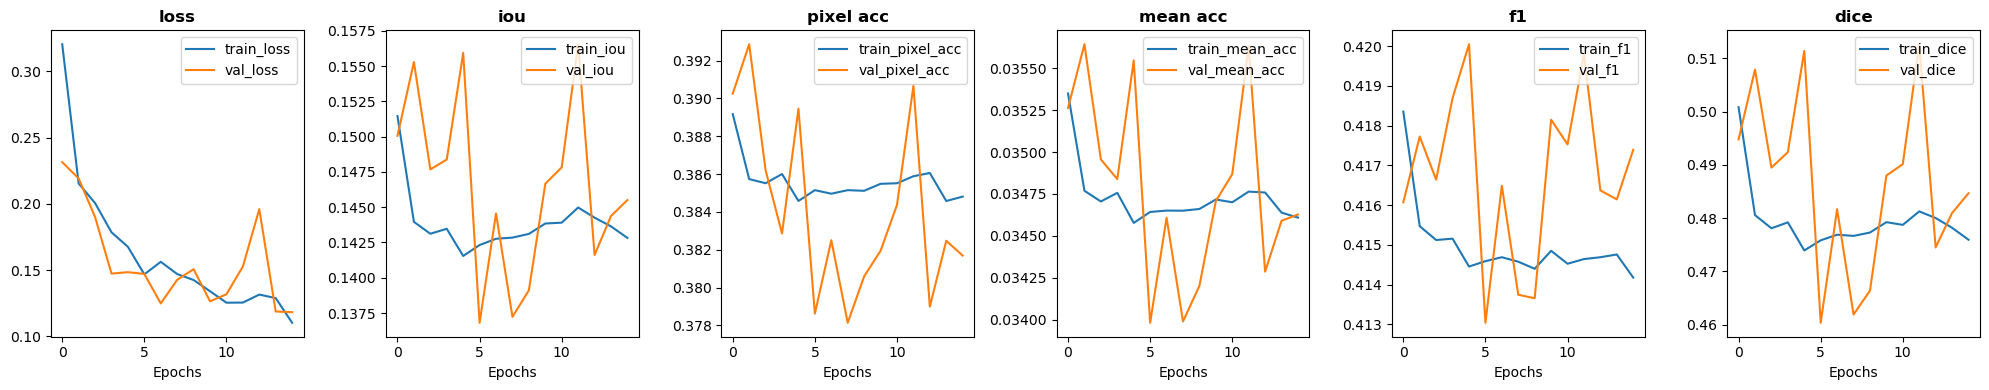

In [27]:
#10-
def plot_history(history):

    fig, axs = plt.subplots(1, 6, figsize=(20, 4))

    for i, (key, values) in enumerate(history.items()):
        col = i % 6
        axs[col].plot(values, label=key)
        axs[col].set_title(' '.join(key.split('_')[1:]), fontweight ='bold')
        axs[col].set_xlabel("Epochs")
        axs[col].legend()

    plt.tight_layout()
    plt.show()
    
plot_history(history)

In [28]:
#11- Evaluate model on the test set
# Load the saved model
checkpoint = torch.load('model_checkpoint_V1.pth')
model.load_state_dict(checkpoint['model_state_dict'])

#trainer = TrainerClass(model, train_loader, val_loader, optimizer, criterion, scheduler, num_epochs=3, early_stopping_patience=5)

# Set the model to evaluation mode
model.eval()

# Test on the test_loader
test_loss, test_iou, test_pixel_acc, test_mean_acc, test_f1, test_dice = trainer.run_one_epoch(test_loader, is_training=False)
print(f'Test Loss: {test_loss:.4f}') 
print(f'Test IoU: {test_iou:.4f}') 
print(f'Test Pixel Acc: {test_pixel_acc:.4f}') 
print(f'Test Mean Acc: {test_mean_acc:.4f}') 
print(f'Test F1: {test_f1:.4f}')
print(f'Test Dice: {test_dice:.4f}')     

Test Loss: 0.2694
Test IoU: 0.1347
Test Pixel Acc: 0.3448
Test Mean Acc: 0.0325
Test F1: 0.4317
Test Dice: 0.4696


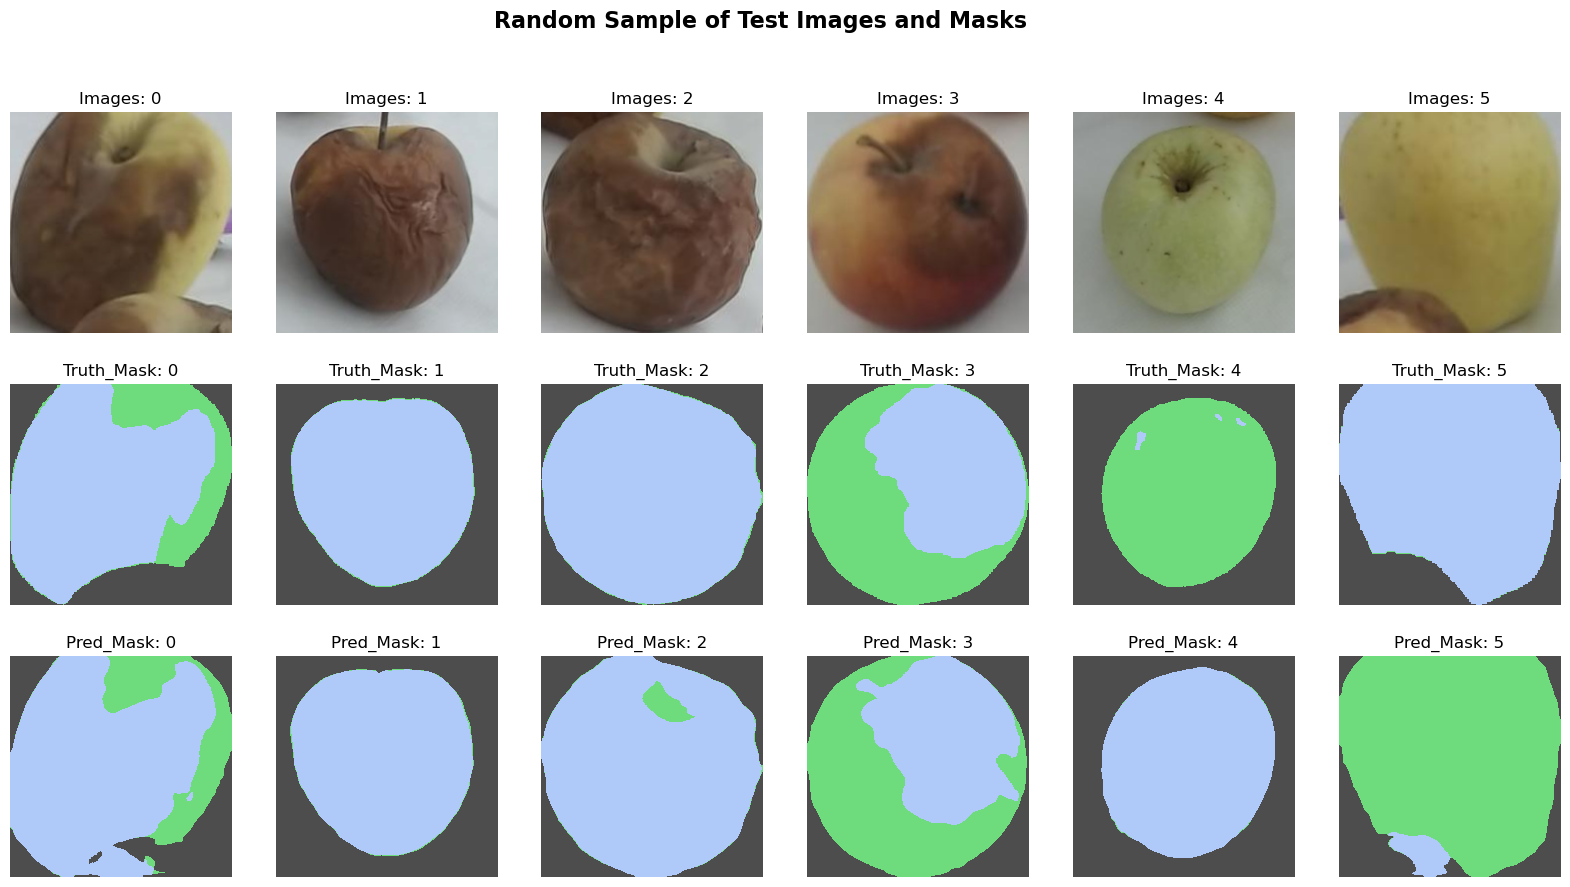

In [34]:
#12- Plot model evaluated on the test set
# Set the random seed for reproducibility
#random.seed(42)
# Load the saved model
checkpoint = torch.load('model_checkpoint_V1.pth')
model.load_state_dict(checkpoint['model_state_dict'])
# Set the model to evaluation mode
model.eval()

# Get a batch of sample images and masks
sample_size = 6
sample_indices = random.sample(range(len(test_loader.dataset)), sample_size)
sample_subset = data.Subset(test_loader.dataset, sample_indices)
sample_loader = data.DataLoader(sample_subset, batch_size=sample_size, shuffle=False)

with torch.no_grad():
    # Get a batch of images and masks from the dataloader
    images, masks = next(iter(sample_loader))
    images = images.to(device)
    masks = masks.to(device)
    output = model(images)
    pred_mask = F.softmax(output, dim=1)
    pred_mask = torch.argmax(pred_mask, dim=1)
    pred_mask = pred_mask.squeeze().cpu().numpy()

    # Create a grid of subplots to plot the sample images and masks
    fig, axs = plt.subplots(3, sample_size, figsize=(20, 10))

    # Plot each image and mask in a separate subplot
    for i in range(sample_size):
        # Plot the image
        axs[0, i].imshow(np.clip(images[i].permute(1,2,0).numpy()* std + mean, 0, 255))
        axs[0, i].set_title('Images: '+str(i))
        axs[0, i].axis("off")

        # Plot the ground truth mask
        axs[1, i].imshow(torch.argmax(masks[i], dim=0), alpha=0.7, cmap=cmap2)
        axs[1, i].set_title('Truth_Mask: '+str(i))
        axs[1, i].axis("off")

        # Plot the predicted mask (assuming it's stored in a variable called mask_predicted)
        mask_predicted = model(images.to(device))
        axs[2, i].imshow(pred_mask[i], alpha=0.7, cmap=cmap2)
        axs[2, i].set_title('Pred_Mask: '+str(i))
        axs[2, i].axis("off")

    # Set the title of the plot
    fig.suptitle("Random Sample of Test Images and Masks", fontsize=16, fontweight='bold')

    # Show the plot
    plt.show()

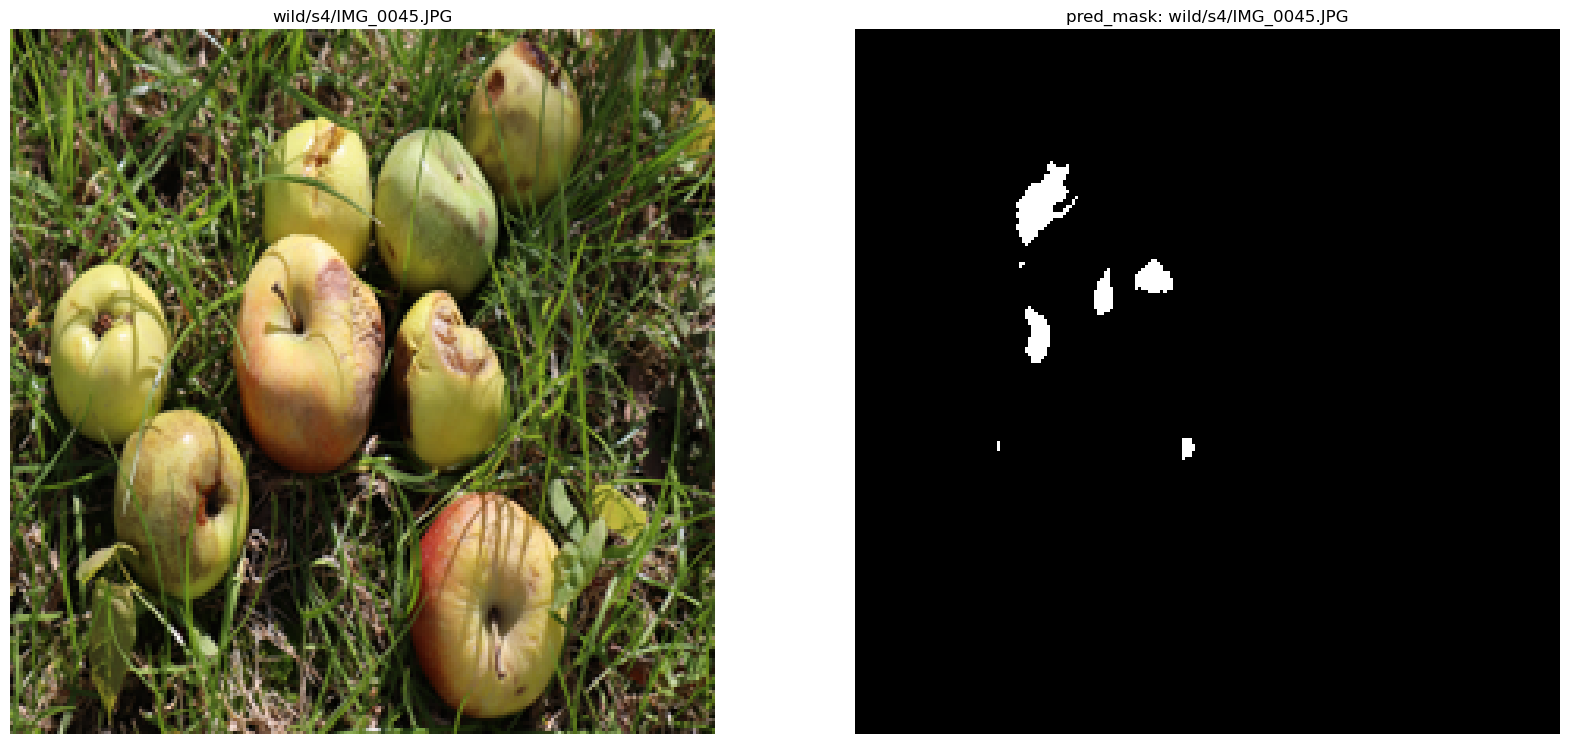

In [35]:
# 13- Use the saved model for inference on new images,

image_inference = folder_wild+'s4/IMG_0045.JPG'

# Load the saved model
checkpoint = torch.load('model_checkpoint_V1.pth')
model.load_state_dict(checkpoint['model_state_dict'])
# Set the model to evaluation mode
model.eval()
# Perform inference on any image
image = Image.open(image_inference).resize((224,224))
transform = transforms.Compose([transforms.Resize((224, 224)), transforms.ToTensor()])
image_tensor = transform(image).unsqueeze(0)

with torch.no_grad():
    output = model(image_tensor.to(device))
    pred_mask = F.softmax(output, dim=1)
    pred_mask = torch.argmax(pred_mask, dim=1)
    pred_mask = pred_mask.squeeze(0).cpu().numpy()
    
fig, axs = plt.subplots(1, 2, figsize=(20, 10))
axs[0].imshow(image)
axs[0].set_title(image_inference)
axs[0].axis("off")

# Plot the pred mask
axs[1].imshow(pred_mask, cmap='gray')
axs[1].set_title('pred_mask: '+image_inference)
axs[1].axis("off")

plt.show()